In [37]:
import math
from abc import abstractmethod

import numpy as np
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from einops import repeat

In [38]:
from abc import ABC, abstractmethod
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [39]:
from abc import ABC, abstractmethod
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd

In [40]:
import json
from os.path import join

input_path = 'E:/dataset/BP-ES/'

for pid in range(1, 27):
    with open(join(input_path, f'{pid}.json'), 'r') as f:
        data = json.load(f)
    
    ppg_len = len(data['data_PPG'])
    num_bp = len(data['data_BP'])
    
    print(f"{pid}.json - PPG length: {ppg_len}, BP measurements: {num_bp}")


1.json - PPG length: 280000, BP measurements: 4
2.json - PPG length: 356000, BP measurements: 6
3.json - PPG length: 346000, BP measurements: 6
4.json - PPG length: 555000, BP measurements: 7
5.json - PPG length: 509000, BP measurements: 7
6.json - PPG length: 270000, BP measurements: 5
7.json - PPG length: 479000, BP measurements: 6
8.json - PPG length: 438000, BP measurements: 6
9.json - PPG length: 342000, BP measurements: 6
10.json - PPG length: 299000, BP measurements: 5
11.json - PPG length: 225000, BP measurements: 6
12.json - PPG length: 387000, BP measurements: 6
13.json - PPG length: 404000, BP measurements: 6
14.json - PPG length: 413000, BP measurements: 6
15.json - PPG length: 355000, BP measurements: 6
16.json - PPG length: 396000, BP measurements: 6
17.json - PPG length: 346000, BP measurements: 6
18.json - PPG length: 346000, BP measurements: 6
19.json - PPG length: 383000, BP measurements: 6
20.json - PPG length: 393000, BP measurements: 6
21.json - PPG length: 398000,

In [41]:
import numpy as np
import pandas as pd
import json
from os.path import join
from scipy import signal

# FSR 기반 처리 함수
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def find_mins(a, num_mins, window):
    found_mins = []
    amax = a.max()
    hwindow = window // 2
    a = np.array(a)
    for _ in range(num_mins):
        found_min = np.argmin(a)
        found_mins.append(found_min)
        a[found_min - hwindow:found_min + hwindow] = amax
    return sorted(found_mins)

# -----------------------------
input_path = 'E:/dataset/BP-ES/'
ppg_window = 1000  # ±1000
segment_length = 2000
min_window = 15000
diff_n = 1000
roll_window = 21

records = []

for pid in range(1, 27):
    with open(join(input_path, f'{pid}.json'), 'r') as f:
        data = json.load(f)

    age = data.get('age', None)
    height = data.get('height', None)
    data_PPG = np.array(data['data_PPG'])
    data_FSR = -np.array(data['data_FSR'], dtype=np.float64)
    data_BP = data['data_BP']
    ppg_len = len(data_PPG)
    num_bp = len(data_BP)

    # 이상값 제거
    max_diff = 50
    data_FSR_outliers = np.abs(data_FSR[1:] - data_FSR[:-1]) > max_diff
    data_FSR_outliers = np.append(data_FSR_outliers, False)
    data_FSR[data_FSR_outliers] = np.nan

    # NaN 보간
    data_FSR_roll_mean = np.nanmean(rolling_window(data_FSR, 10), axis=-1)
    data_FSR[np.isnan(data_FSR)] = data_FSR_roll_mean[np.isnan(data_FSR)[:1 - 10]]
    data_FSR_smooth = signal.savgol_filter(data_FSR, 51, 0)

    # FSR 변화량
    data_FSR_diff = data_FSR_smooth[diff_n:] - data_FSR_smooth[:-diff_n]
    data_FSR_diff_roll = rolling_window(data_FSR_diff, roll_window).mean(axis=-1)

    # BP 측정 시점 찾기
    data_FSR_mins = find_mins(data_FSR_diff_roll, num_bp, min_window)
    aligned_mins = [int(m + diff_n / 2) for m in data_FSR_mins]

    # 세그먼트 추출
    for i, center in enumerate(aligned_mins):
        sbp = data_BP[i]['SBP']
        dbp = data_BP[i]['DBP']
        start = center - ppg_window
        end = center + ppg_window

        if start >= 0 and end <= ppg_len:
            segment = data_PPG[start:end]
            row = {
                'UID': pid,
                'age': age,
                'height': height,
                'SBP': sbp,
                'DBP': dbp
            }
            # PPG_0 ~ PPG_1999
            for j, val in enumerate(segment):
                row[f'PPG_{j}'] = val
            records.append(row)
        else:
            print(f"🔸 Skip: UID={pid}, BP_idx={i+1}, out-of-bounds [{start}:{end}]")

# DataFrame 생성
df_all_flat = pd.DataFrame(records)
print("✅ 최종 샘플 수:", len(df_all_flat))
print("✅ 컬럼 수:", df_all_flat.shape[1])
print(df_all_flat.head(2))


✅ 최종 샘플 수: 152
✅ 컬럼 수: 2005
   UID  age  height  SBP  DBP  PPG_0  PPG_1  PPG_2  PPG_3  PPG_4  ...  \
0    1   25     175  141   82   2067   2074   2066   2072   2072  ...   
1    1   25     175  134   73   2226   2223   2222   2226   2219  ...   

   PPG_1990  PPG_1991  PPG_1992  PPG_1993  PPG_1994  PPG_1995  PPG_1996  \
0      2248      2155      2248      2249      2250      2250      2066   
1      2085      2088      2090      2090      2094      2094      2098   

   PPG_1997  PPG_1998  PPG_1999  
0      2250      2251      2250  
1      2099      2102      2104  

[2 rows x 2005 columns]


In [42]:
df_all_flat.shape

(152, 2005)

In [43]:
df_all_flat['UID'].value_counts()

UID
4     7
5     7
22    7
14    6
2     6
25    6
21    6
20    6
19    6
18    6
17    6
16    6
15    6
26    6
13    6
12    6
11    6
9     6
8     6
7     6
3     6
10    5
6     5
24    5
23    4
1     4
Name: count, dtype: int64

In [44]:
df_all_flat

,UID,age,height,SBP,DBP,PPG_0,PPG_1,PPG_2,PPG_3,PPG_4,...,PPG_1990,PPG_1991,PPG_1992,PPG_1993,PPG_1994,PPG_1995,PPG_1996,PPG_1997,PPG_1998,PPG_1999
0,1,25,175,141,82,2067,2074,2066,2072,2072,...,2248,2155,2248,2249,2250,2250,2066,2250,2251,2250
1,1,25,175,134,73,2226,2223,2222,2226,2219,...,2085,2088,2090,2090,2094,2094,2098,2099,2102,2104
2,1,25,175,125,70,2130,2130,2126,2123,2130,...,2347,2351,2351,2354,2354,2354,2354,2354,2354,2354
3,1,25,175,118,57,2114,2113,2112,2112,2112,...,2216,2216,2207,2207,2207,2207,2207,2206,2200,2200
4,2,24,179,152,84,1961,1962,1960,1962,1960,...,2070,2066,2063,2062,2062,2060,2057,2056,2056,2056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,26,24,170,146,80,1674,1674,1676,1675,1674,...,1960,1960,1955,1955,1954,1950,1950,1946,1946,1946
148,26,24,170,142,68,1809,1807,1804,1804,1801,...,1912,1906,1906,1902,1902,1902,1899,1897,1896,1896
149,26,24,170,135,73,1771,1768,1768,1767,1766,...,1813,1817,1811,1807,1809,1810,1807,1807,1805,1802
150,26,24,170,129,70,1760,1754,1753,1755,1749,...,1935,1931,1930,1930,1928,1923,1920,1920,1915,1913


In [47]:
# 고혈압 여부 판단 함수
def is_hypertension(sbp, dbp):
    return int(sbp >= 140 or dbp >= 90)

# Hypertion 컬럼 추가
df_all_flat['Hypertion'] = df_all_flat.apply(lambda row: is_hypertension(row['SBP'], row['DBP']), axis=1)

# 결과 확인
print(df_all_flat[['UID', 'SBP', 'DBP', 'Hypertion']].head(10))
print("고혈압 샘플 수:", df_all_flat['Hypertion'].sum())
print("정상 샘플 수:", (df_all_flat['Hypertion'] == 0).sum())


   UID  SBP  DBP  Hypertion
0    1  141   82          1
1    1  134   73          0
2    1  125   70          0
3    1  118   57          0
4    2  152   84          1
5    2  141   81          1
6    2  122   76          0
7    2  123   69          0
8    2  122   70          0
9    2  120   69          0
고혈압 샘플 수: 58
정상 샘플 수: 94


In [95]:
df_all_flat.to_csv('E:/dataset/BP-ES/ppg_all_flat.csv', index=False)
print("✅ 'ppg_all_flat.csv' 파일로 저장 완료.")

✅ 'ppg_all_flat.csv' 파일로 저장 완료.


In [48]:
# UID별 샘플 수 집계
uid_sample_counts = df_all_flat.groupby('UID').size().reset_index(name='Num_Samples')

# UID별 고혈압 여부 집계 (1개라도 고혈압이면 전체 고혈압자로 간주)
uid_hyper_status = df_all_flat.groupby('UID')['Hypertion'].max().reset_index()

# 병합
uid_summary = pd.merge(uid_sample_counts, uid_hyper_status, on='UID')

# Hypertion을 int로
uid_summary['Hypertion'] = uid_summary['Hypertion'].astype(int)

# 정렬 (선택)
uid_summary = uid_summary.sort_values('UID').reset_index(drop=True)

# 출력
print(uid_summary.head(10))
print(f"\n전체 환자 수: {len(uid_summary)}")
print(f"  - 고혈압 환자 수: {uid_summary['Hypertion'].sum()}")
print(f"  - 정상 환자 수: {(uid_summary['Hypertion'] == 0).sum()}")



   UID  Num_Samples  Hypertion
0    1            4          1
1    2            6          1
2    3            6          0
3    4            7          1
4    5            7          1
5    6            5          1
6    7            6          1
7    8            6          1
8    9            6          1
9   10            5          0

전체 환자 수: 26
  - 고혈압 환자 수: 19
  - 정상 환자 수: 7


In [49]:
# 고혈압 여부 판단 함수
def is_hypertension(sbp, dbp):
    return int(sbp >= 140 or dbp >= 90)

# Hypertion 컬럼 추가
df_all_flat['Hypertion'] = df_all_flat.apply(lambda row: is_hypertension(row['SBP'], row['DBP']), axis=1)

# 결과 확인
print(df_all_flat[['UID', 'SBP', 'DBP', 'hypertension']].head(10))
print("고혈압 샘플 수:", df_all_flat['hypertension'].sum())
print("정상 샘플 수:", (df_all_flat['hypertension'] == 0).sum())


   UID  SBP  DBP  Hypertion
0    1  141   82          1
1    1  134   73          0
2    1  125   70          0
3    1  118   57          0
4    2  152   84          1
5    2  141   81          1
6    2  122   76          0
7    2  123   69          0
8    2  122   70          0
9    2  120   69          0
고혈압 샘플 수: 58
정상 샘플 수: 94


In [50]:
import pandas as pd

# 전체 세그먼트 수
total_per_uid = df_all_flat.groupby('UID').size().rename('Total_Segments')

# 정상 세그먼트 수 (Hypertion == 0)
normal_per_uid = df_all_flat[df_all_flat['Hypertion'] == 0].groupby('UID').size().rename('Normal_Segments')

# 고혈압 세그먼트 수 (Hypertion == 1)
hyper_per_uid = df_all_flat[df_all_flat['Hypertion'] == 1].groupby('UID').size().rename('Hyper_Segments')

# 병합
uid_segment_summary = pd.concat([total_per_uid, normal_per_uid, hyper_per_uid], axis=1).fillna(0)
uid_segment_summary = uid_segment_summary.astype(int).reset_index()

# UID 순 정렬
uid_segment_summary = uid_segment_summary.sort_values('UID').reset_index(drop=True)

# 출력
print(uid_segment_summary)

# 선택 저장
uid_segment_summary.to_csv("uid_segment_summary_table.csv", index=False)



    UID  Total_Segments  Normal_Segments  Hyper_Segments
0     1               4                3               1
1     2               6                4               2
2     3               6                6               0
3     4               7                0               7
4     5               7                5               2
5     6               5                2               3
6     7               6                1               5
7     8               6                2               4
8     9               6                1               5
9    10               5                5               0
10   11               6                2               4
11   12               6                3               3
12   13               6                3               3
13   14               6                3               3
14   15               6                6               0
15   16               6                5               1
16   17               6        

In [51]:
# UID별 고혈압 세그먼트 수 집계
hyper_per_uid = df_all_flat[df_all_flat['Hypertion'] == 1].groupby('UID').size().rename('Hyper_Segments')

# 전체 UID 목록
all_uids = df_all_flat['UID'].unique()

# 고혈압 세그먼트가 0개인 UID = 전체 UID 중 hyper_per_uid에 없는 UID
uids_no_hypertension = [uid for uid in all_uids if uid not in hyper_per_uid.index]

print("✅ 고혈압(Hypertion=1) 세그먼트가 하나도 없는 UID 목록:")
print(uids_no_hypertension)

print(f"총 {len(uids_no_hypertension)}명")


✅ 고혈압(Hypertion=1) 세그먼트가 하나도 없는 UID 목록:
[3, 10, 15, 17, 18, 20, 25]
총 7명


In [52]:
# 훈련용 UID 목록
train_uids = [3, 10, 15, 17, 18]

# 데이터 분할
df_train = df_all_flat[df_all_flat['UID'].isin(train_uids)].reset_index(drop=True)
df_test = df_all_flat[~df_all_flat['UID'].isin(train_uids)].reset_index(drop=True)

# 결과 확인
print("✅ 훈련 데이터:")
print(f" - 샘플 수: {len(df_train)}")
print(f" - UID 수: {df_train['UID'].nunique()}")
print(f" - 고혈압 샘플 수: {df_train['hypertension'].sum()}")

print("\n✅ 테스트 데이터:")
print(f" - 샘플 수: {len(df_test)}")
print(f" - UID 수: {df_test['UID'].nunique()}")
print(f" - 고혈압 샘플 수: {df_test['hypertension'].sum()}")


✅ 훈련 데이터:
 - 샘플 수: 29
 - UID 수: 5
 - 고혈압 샘플 수: 0

✅ 테스트 데이터:
 - 샘플 수: 123
 - UID 수: 21
 - 고혈압 샘플 수: 58


In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def timestep_embedding(timesteps, dim, max_period=1000, repeat_only=False):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                        These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    if not repeat_only:
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period)
            * torch.arange(start=0, end=half, dtype=torch.float32)
            / half
        ).to(device=timesteps.device)
        args = timesteps[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
    else:
        embedding = repeat(timesteps, "b -> b d", d=dim)
    return embedding


def zero_module(module):
    """
    Zero out the parameters of a module and return it.
    """
    for p in module.parameters():
        p.detach().zero_()
    return module


class TimestepBlock(nn.Module):
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """
        raise NotImplementedError

class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    """
    A sequential module that passes timestep embeddings to the children that
    support it as an extra input.
    """

    def forward(self, x, emb, context=None):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)  # Pass emb to TimestepBlock layers
            else:
                x = layer(x)  # Regular layers do not receive emb
        return x

def Normalize(in_channels):
    return nn.GroupNorm(
        num_groups=32, num_channels=in_channels, eps=1e-6, affine=True
    )


def count_flops_attn(model, _x, y):
    """
    A counter for the `thop` package to count the operations in an
    attention operation.
    Meant to be used like:
        macs, params = thop.profile(
            model,
            inputs=(inputs, timestamps),
            custom_ops={QKVAttention: QKVAttention.count_flops},
        )
    """
    b, c, *spatial = y[0].shape
    num_spatial = int(np.prod(spatial))
    # We perform two matmuls with the same number of ops.
    # The first computes the weight matrix, the second computes
    # the combination of the value vectors.
    matmul_ops = 2 * b * (num_spatial**2) * c
    model.total_ops += th.DoubleTensor([matmul_ops])


class QKVAttentionLegacy(nn.Module):
    """
    A module which performs QKV attention.
    Matches legacy QKVAttention + input/ouput heads shaping
    """

    def __init__(self, n_heads):
        super().__init__()
        self.n_heads = n_heads

    def forward(self, qkv):
        """
        Apply QKV attention.
        :param qkv: an [N x (H * 3 * C) x T] tensor of Qs, Ks, and Vs.
        :return: an [N x (H * C) x T] tensor after attention.
        """
        bs, width, length = qkv.shape
        assert width % (3 * self.n_heads) == 0
        ch = width // (3 * self.n_heads)
        q, k, v = qkv.reshape(bs * self.n_heads, ch * 3, length).split(
            ch, dim=1
        )
        scale = 1 / math.sqrt(math.sqrt(ch))
        weight = torch.einsum(
            "bct,bcs->bts", q * scale, k * scale
        )  # More stable with f16 than dividing afterwards
        weight = torch.softmax(weight.float(), dim=-1).type(weight.dtype)
        a = torch.einsum("bts,bcs->bct", weight, v)
        return a.reshape(bs, -1, length)

    @staticmethod
    def count_flops(model, _x, y):
        return count_flops_attn(model, _x, y)


class AttentionBlock(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other.
    Originally ported from here, but adapted to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    """

    def __init__(
        self,
        channels,
        num_heads=1,
        num_head_channels=-1,
        use_checkpoint=False,
    ):
        super().__init__()
        self.channels = channels
        if num_head_channels == -1:
            self.num_heads = num_heads
        else:
            assert channels % num_head_channels == 0, (
                f"q,k,v channels {channels} is "
                f"not divisible by num_head_channels {num_head_channels}"
            )
            self.num_heads = channels // num_head_channels
        self.use_checkpoint = use_checkpoint
        self.norm = Normalize(channels)
        self.qkv = nn.Conv1d(channels, channels * 3, 1)
        self.attention = QKVAttentionLegacy(self.num_heads)

        self.proj_out = zero_module(nn.Conv1d(channels, channels, 1))

    def forward(self, x):
        return self._forward(
            x,
        )

    def _forward(self, x):
        b, c, *spatial = x.shape
        x = x.reshape(b, c, -1)
        qkv = self.qkv(self.norm(x))
        h = self.attention(qkv)
        h = self.proj_out(h)
        return (x + h).reshape(b, c, *spatial)


class Downsample(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        if use_conv:
            self.op = nn.Conv1d(
                self.channels, self.out_channels, 3, stride=2, padding=padding
            )#TODO:Mudar
        else:
            assert self.channels == self.out_channels
            self.op = nn.AvgPool1d(kernel_size=2, stride=2)#TODO: Mudar

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class Upsample(nn.Module):
    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs.
    :param use_conv: a bool determining if a convolution is applied.
    """

    def __init__(self, channels, use_conv, out_channels=None, padding=1):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        if use_conv:
            self.conv = nn.Conv1d(
                self.channels, self.out_channels, 3, padding=padding
            )#TODO:Mudar

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        if self.use_conv:
            x = self.conv(x)
        return x


class ResBlock(TimestepBlock):  # Ensure ResBlock inherits from TimestepBlock
    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
        use_conv=False,
        use_scale_shift_norm=False,
        up=False,
        down=False,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_scale_shift_norm = use_scale_shift_norm

        self.in_layers = nn.Sequential(
            Normalize(channels),
            nn.SiLU(),
            nn.Conv1d(channels, self.out_channels, 3, padding=1),
        )

        self.updown = up or down

        if up:
            self.h_upd = Upsample(channels, False)
            self.x_upd = Upsample(channels, False)
        elif down:
            self.h_upd = Downsample(channels, False)
            self.x_upd = Downsample(channels, False)
        else:
            self.h_upd = self.x_upd = nn.Identity()

        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_channels,
                2 * self.out_channels
                if use_scale_shift_norm
                else self.out_channels,
            ),
        )
        self.out_layers = nn.Sequential(
            Normalize(self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(
                nn.Conv1d(self.out_channels, self.out_channels, 3, padding=1)
            ),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        elif use_conv:
            self.skip_connection = nn.Conv1d(
                channels, self.out_channels, kernel_size=1
            )
        else:
            self.skip_connection = nn.Conv1d(channels, self.out_channels, kernel_size=1)

    def forward(self, x, emb):
        """
        Apply the ResBlock to `x` with timestep embeddings `emb`.
        """
        if self.updown:
            in_rest, in_conv = self.in_layers[:-1], self.in_layers[-1]
            h = in_rest(x)
            h = self.h_upd(h)
            x = self.x_upd(x)
            h = in_conv(h)
        else:
            h = self.in_layers(x)

        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]

        if self.use_scale_shift_norm:
            out_norm, out_rest = self.out_layers[0], self.out_layers[1:]
            scale, shift = torch.chunk(emb_out, 2, dim=1)
            h = out_norm(h) * (1 + scale) + shift
            h = out_rest(h)
        else:
            h = h + emb_out
            h = self.out_layers(h)

        return self.skip_connection(x) + h

class UNetModel(nn.Module):
    def __init__(
        self,
        image_size=11000,
        in_channels=1,
        model_channels=32,
        out_channels=1,
        num_res_blocks=2,
        attention_resolutions=[16, 8],
        dropout=0.1,
        channel_mult=(2, 4, 8),
        num_heads=4,
        use_scale_shift_norm=False,
        resblock_updown=True,
    ):
        super().__init__()

        self.image_size = image_size
        self.in_channels = in_channels
        self.model_channels = model_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.attention_resolutions = attention_resolutions
        self.dropout = dropout
        self.channel_mult = channel_mult
        self.num_heads = num_heads
        self.use_scale_shift_norm = use_scale_shift_norm
        self.resblock_updown = resblock_updown

        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.input_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv1d(in_channels, model_channels, 3, padding=1))
        ])
        input_block_chans = [model_channels]
        ch = model_channels
        ds = 1

        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResBlock(ch, time_embed_dim, dropout, out_channels=mult * model_channels, use_scale_shift_norm=use_scale_shift_norm)]
                ch = mult * model_channels
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                out_ch = ch
                self.input_blocks.append(TimestepEmbedSequential(Downsample(ch, True, out_channels=out_ch)))
                ch = out_ch
                input_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResBlock(ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm),
            AttentionBlock(ch, num_heads=num_heads),
            ResBlock(ch, time_embed_dim, dropout, use_scale_shift_norm=use_scale_shift_norm),
        )

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                ich = input_block_chans.pop()
                layers = [ResBlock(ch + ich, time_embed_dim, dropout, out_channels=model_channels * mult, use_scale_shift_norm=use_scale_shift_norm)]
                ch = model_channels * mult
                if ds in attention_resolutions:
                    layers.append(AttentionBlock(ch, num_heads=num_heads))
                if level and i == num_res_blocks:
                    out_ch = ch
                    layers.append(Upsample(ch, True, out_channels=out_ch))
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            Normalize(ch),
            nn.SiLU(),
            zero_module(nn.Conv1d(ch, out_channels, 3, padding=1)),
        )

    def forward(self, x, timesteps=None, context=None, y=None):
        assert timesteps is not None, "timesteps must be provided"
        hs = []
        t_emb = timestep_embedding(timesteps, self.model_channels, repeat_only=False)
        emb = self.time_embed(t_emb)

        h = x
        for module in self.input_blocks:
            h = module(h, emb, context)
            hs.append(h)
        h = self.middle_block(h, emb, context)

        for module in self.output_blocks:
            h_pop = hs.pop()
            if h.shape[2] != h_pop.shape[2]:
                h_pop = F.interpolate(h_pop, size=h.shape[2], mode='nearest')
            h = torch.cat([h, h_pop], dim=1)
            h = module(h, emb, context)

        return self.out(h)


from functools import partial
from inspect import isfunction

import numpy as np
import torch as th

def exists(x):
    return x is not None


def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d


def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(
        shape[0], *((1,) * (len(shape) - 1))
    )
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()


def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def make_beta_schedule(
    schedule, n_timestep, linear_start=1e-4, linear_end=2e-2, cosine_s=8e-3
):
    if schedule == "linear":
        betas = (
            torch.linspace(
                linear_start**0.5,
                linear_end**0.5,
                n_timestep,
                dtype=torch.float64,
            )
            ** 2
        )

    elif schedule == "cosine":
        timesteps = (
            torch.arange(n_timestep + 1, dtype=torch.float64) / n_timestep
            + cosine_s
        )
        alphas = timesteps / (1 + cosine_s) * np.pi / 2
        alphas = torch.cos(alphas).pow(2)
        alphas = alphas / alphas[0]
        betas = 1 - alphas[1:] / alphas[:-1]
        betas = np.clip(betas, a_min=0, a_max=0.999)

    elif schedule == "sqrt_linear":
        betas = torch.linspace(
            linear_start, linear_end, n_timestep, dtype=torch.float64
        )
    elif schedule == "sqrt":
        betas = (
            torch.linspace(
                linear_start, linear_end, n_timestep, dtype=torch.float64
            )
            ** 0.5
        )
    else:
        raise ValueError(f"schedule '{schedule}' unknown.")
    return betas.numpy()

import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from functools import partial

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

class DDIM(nn.Module):
    def __init__(
        self,
        unet_config,
        timesteps=1000,
        ddim_steps=50,
        beta_schedule="linear",
        clip_denoised=False,
        linear_start=1e-4,
        linear_end=2e-2,
        original_elbo_weight=0.0,
        parameterization="eps",
    ):
        super().__init__()
        assert parameterization in ["eps", "x0"], 'Only "eps" and "x0" are supported.'
        self.parameterization = parameterization
        self.model = UNetModel(**unet_config.get("params", {}))
        self.clip_denoised = clip_denoised
        self.original_elbo_weight = original_elbo_weight
        self.ddim_steps = ddim_steps
        self.register_schedule(beta_schedule, timesteps, linear_start, linear_end)

    def register_schedule(self, beta_schedule, timesteps, linear_start, linear_end):
        betas = np.linspace(linear_start, linear_end, timesteps, dtype=np.float64)
        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        self.num_timesteps = int(timesteps)
        to_torch = partial(torch.tensor, dtype=torch.float32)

        self.register_buffer("betas", to_torch(betas))
        self.register_buffer("alphas_cumprod", to_torch(alphas_cumprod))
        self.register_buffer("alphas_cumprod_prev", to_torch(alphas_cumprod_prev))
        self.register_buffer("sqrt_recip_alphas_cumprod", to_torch(np.sqrt(1.0 / alphas_cumprod)))
        self.register_buffer("sqrt_one_minus_alphas_cumprod", to_torch(np.sqrt(1.0 - alphas_cumprod)))

    def ddim_sample(self, x, t, eta=0.0):
        model_output = self.model(x, t)

        if self.parameterization == "eps":
            pred_x0 = extract(self.sqrt_recip_alphas_cumprod, t, x.shape) * x - \
                        extract(self.sqrt_one_minus_alphas_cumprod, t, x.shape) * model_output
        else:
            pred_x0 = model_output

        if self.clip_denoised:
            pred_x0 = torch.clamp(pred_x0, -1.0, 1.0)

        sigma = eta * (1 - extract(self.alphas_cumprod, t, x.shape)).sqrt()
        noise = torch.randn_like(x)

        return pred_x0 + sigma * noise

    @torch.no_grad()
    def p_sample_loop_ddim(self, shape, eta=0.0):
        device = self.betas.device
        img = torch.randn(shape, device=device)

        for i in tqdm(reversed(range(0, self.ddim_steps)), desc="DDIM sampling"):
            t = torch.full((shape[0],), i, device=device, dtype=torch.long)
            img = self.ddim_sample(img, t, eta)

        return img

    @torch.no_grad()
    def sample(self, batch_size=16, eta=0.0):
        image_size = self.model.image_size
        channels = self.model.in_channels
        return self.p_sample_loop_ddim((batch_size, channels, image_size), eta=eta)

    def forward(self, x, t):
        return self.model(x, t)


In [54]:
df_train.columns

Index(['UID', 'age', 'height', 'SBP', 'DBP', 'PPG_0', 'PPG_1', 'PPG_2',
       'PPG_3', 'PPG_4',
       ...
       'PPG_1991', 'PPG_1992', 'PPG_1993', 'PPG_1994', 'PPG_1995', 'PPG_1996',
       'PPG_1997', 'PPG_1998', 'PPG_1999', 'Hypertion'],
      dtype='object', length=2006)

In [61]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

# 'subject' 열 제거
train_df_no_subject = df_train.drop(columns=['UID', 'age', 'height', 'SBP', 'DBP', 'hypertension'])

# 텐서로 변환
train_data_tensor = torch.tensor(train_df_no_subject.values, dtype=torch.float32)

# TensorDataset 및 DataLoader 생성
train_dataset = TensorDataset(train_data_tensor)  # 레이블 없음
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [62]:
print("Train tensor shape:", train_data_tensor.shape)

Train tensor shape: torch.Size([29, 2000])


In [63]:
train_df_no_subject

,PPG_0,PPG_1,PPG_2,PPG_3,PPG_4,PPG_5,PPG_6,PPG_7,PPG_8,PPG_9,...,PPG_1990,PPG_1991,PPG_1992,PPG_1993,PPG_1994,PPG_1995,PPG_1996,PPG_1997,PPG_1998,PPG_1999
0,2106,2106,2104,2104,2104,2106,2104,2104,2104,2104,...,1986,1990,1987,1987,1988,1987,1987,1987,1987,1992
1,2075,2074,2075,2074,2074,2074,2070,2072,2072,2067,...,2072,2072,2067,2066,2066,2062,2063,2062,2059,2059
2,2038,2036,2034,2034,2034,2029,2030,2028,2024,2027,...,1946,1946,1944,1944,1944,1944,1944,1944,1939,1939
3,2067,2072,2067,2066,2067,2062,2062,2057,2059,2056,...,1922,1926,1923,1928,1931,1934,1935,1935,1939,1939
4,2099,2104,2099,2098,2099,2099,2095,2099,2096,2095,...,1984,1984,1978,1976,1976,1971,1971,1967,1967,1963
5,2095,2098,2098,2104,2106,2106,2107,2107,2112,2106,...,1966,1960,1960,1960,1955,1951,1947,1947,1946,1944
6,1984,1986,1984,1984,1979,1979,1982,1979,1984,1979,...,1976,1970,1971,1970,1971,1970,1967,1970,1966,1966
7,1888,1888,1886,1888,1886,1886,1886,1886,1886,1883,...,1947,1944,1944,1944,1939,1944,1938,1938,1935,1934
8,1891,1888,1888,1890,1888,1888,1883,1886,1883,1883,...,2010,2012,2018,2012,2014,2011,2015,2014,2015,2017
9,1842,1839,1839,1839,1838,1842,1843,1838,1842,1839,...,1984,1984,1984,1984,1986,1984,1990,1987,1990,1988


In [93]:
import os
import torch
from torch import optim # Import optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import torch.nn as nn
import torch.nn.functional as F
import math

# 학습 함수
def train_ddim_model(model, train_loader, num_epochs=20, learning_rate=1e-4, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            x = batch[0].to(device)  # 레이블이 없으므로 x만 가져옴
            # x = x.unsqueeze(1)  # Remove this line - it's causing the error

            # Reshape x to have the expected shape (batch_size, in_channels, image_size)
            x = x.view(x.shape[0], unet_config["params"]["in_channels"], -1)
            t = torch.randint(0, model.num_timesteps, (x.shape[0],), device=device).long()

            optimizer.zero_grad()
            loss = loss_fn(model(x, t), x)  # 모델의 출력과 입력 비교 (재구성 손실)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}: Avg Train Loss = {avg_loss:.4f}")

# 모델 초기화
device = 'cuda' if torch.cuda.is_available() else 'cpu'

unet_config = {
    "params": {
        "image_size": 11000,          # 시퀀스 길이 그대로 사용
        "in_channels": 1,          # 1채널 입력 (기본적인 경우)
        "model_channels": 32,
        "out_channels": 1,
        "num_res_blocks": 2,
        "attention_resolutions": [13],  # 52를 downsample했을 때 포함되는 해상도
        "dropout": 0.1,
        "channel_mult": (2, 4, 8),
        "num_heads": 4,
        "use_scale_shift_norm": False,
        "resblock_updown": True,
    }
}
import time

# 학습 시간 측정 시작
start_time = time.time()

ddim_model = DDIM(unet_config=unet_config, timesteps=2000, ddim_steps=50, parameterization='eps').to(device)

# 학습 시작
train_ddim_model(ddim_model, train_loader, num_epochs=5, learning_rate=1e-4, device=device)

# 학습 시간 측정 종료
end_time = time.time()
elapsed_time = end_time - start_time

# 시간 출력
minutes, seconds = divmod(elapsed_time, 60)
print(f"\n⏱️ 학습 완료! 총 소요 시간: {int(minutes)}분 {seconds:.2f}초")

Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Epoch 1: Avg Train Loss = 4401709.5000


Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.25s/it]


Epoch 2: Avg Train Loss = 4401672.5000


Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.93s/it]


Epoch 3: Avg Train Loss = 4401633.5000


Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


Epoch 4: Avg Train Loss = 4401594.5000


Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.53s/it]

Epoch 5: Avg Train Loss = 4401554.5000

⏱️ 학습 완료! 총 소요 시간: 0분 21.96초


In [96]:
df_test.shape

(123, 2006)

In [97]:
df_test.columns

Index(['UID', 'age', 'height', 'SBP', 'DBP', 'PPG_0', 'PPG_1', 'PPG_2',
       'PPG_3', 'PPG_4',
       ...
       'PPG_1991', 'PPG_1992', 'PPG_1993', 'PPG_1994', 'PPG_1995', 'PPG_1996',
       'PPG_1997', 'PPG_1998', 'PPG_1999', 'Hypertion'],
      dtype='object', length=2006)

In [98]:
# 입력 텐서
test_features = df_test.drop(columns=['UID', 'age', 'height','SBP', 'DBP','Hypertion']).values
test_data_tensor = torch.tensor(test_features, dtype=torch.float32).unsqueeze(1)  # (44, 1, 11000)

# 레이블 텐서
test_labels_tensor = torch.tensor(df_test["Hypertion"].values, dtype=torch.float32).unsqueeze(-1)

# subject 텐서
subject_tensor = torch.tensor(df_test["UID"].values, dtype=torch.int32).unsqueeze(-1)

# TensorDataset 생성
test_dataset = TensorDataset(test_data_tensor, test_labels_tensor, subject_tensor)

# DataLoader 생성
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [99]:
test_data_tensor.shape

torch.Size([123, 1, 2000])

In [100]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm import tqdm

def test_ddim_model(model, test_loader, device='cuda'):
    model.to(device)
    model.eval()

    results = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing Model"):
            if isinstance(batch, (tuple, list)):
                if len(batch) == 2:
                    x, y = batch
                else:
                    x, y = batch[0], batch[1]
            else:
                raise ValueError("Batch must be a tuple or list containing at least input and label.")

            x, y = x.to(device), y.to(device)

            # in_channels 설정
            in_channels = getattr(model, "unet_config", {}).get("params", {}).get("in_channels", 1)
            x = x.view(x.shape[0], in_channels, -1)

            t = torch.randint(0, model.num_timesteps, (x.shape[0],), device=device).long()
            pred = model(x, t)

            # 샘플별 reconstruction loss 계산
            sample_losses = ((x - pred) ** 2).mean(dim=[1, 2])  # [batch_size]

            for i in range(x.shape[0]):
                results.append({
                    'Reconstruction_Loss': sample_losses[i].item(),
                    'Label': y[i].item()
                })

    return pd.DataFrame(results)

df_results = test_ddim_model(ddim_model, test_loader, device=device)

Testing Model: 100%|█████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.54s/it]


In [101]:
import torch
import torch.nn.functional as F
import pandas as pd
import time


@torch.no_grad()
def partial_reverse_ddim(model, x_noisy, start_step, end_step=0, eta=0.0):
    assert start_step > end_step, "start_step must be greater than end_step"
    img = x_noisy.to(model.betas.device)

    for i in range(start_step, end_step, -1):
        t = torch.full((img.shape[0],), i, device=img.device, dtype=torch.long)
        img = model.ddim_sample(img, t, eta)

    return img


def test_partial_diffusion(ddpm, test_loader, device, start_step=900, end_step=800, eta=0.0):
    ddpm.eval()
    total_loss = 0
    num_samples = 0
    all_reconstruction_errors = []
    true_labels = []
    subject_ids = []

    with torch.no_grad():
        for batch in test_loader:
            x, labels, subjects = batch
            x = x.to(device)
            labels = labels.to(device)

            noise = torch.randn_like(x)  # 노이즈 생성
            reconstructed_x = partial_reverse_ddim(ddpm, noise, start_step=start_step, end_step=end_step, eta=eta)

            # shape mismatch 방지
            min_len = min(x.shape[2], reconstructed_x.shape[2])
            x = x[:, :, :min_len]
            reconstructed_x = reconstructed_x[:, :, :min_len]

            # MAE 기반 reconstruction error 계산
            reconstruction_error = F.l1_loss(reconstructed_x, x, reduction='none').mean(dim=[1, 2])
            loss = reconstruction_error.mean()

            total_loss += loss.item() * x.size(0)
            num_samples += x.size(0)

            all_reconstruction_errors.extend(reconstruction_error.cpu().numpy().tolist())
            true_labels.extend(labels.cpu().numpy().flatten().tolist())
            subject_ids.extend(subjects.cpu().numpy().flatten().tolist())

    avg_loss = total_loss / num_samples
    anomaly_df = pd.DataFrame({
        "Subject": subject_ids,
        "True_Label": true_labels,
        "Reconstruction_Error": all_reconstruction_errors
    })

    print(f"✅ 최종 테스트 손실 (Partial Diffusion MAE 기반): {avg_loss:.4f}")
    return anomaly_df, avg_loss, None


# 실행 코드 블록
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")


    # 테스트 시간 측정 시작
    start_time = time.time()
    
    # 테스트 실행 (시작/종료 step은 필요 시 조정)
    anomaly_df, test_loss, _ = test_partial_diffusion(ddim_model, test_loader, device, start_step=100, end_step=50)

    # 결과 출력
    print("\n📋 테스트 결과 상위 5개:")
    print(anomaly_df.head())

    print(f"\n✅ Test Loss (MAE): {test_loss:.4f}")


    # 테스트 시간 측정 종료
    end_time = time.time()
    elapsed_time = end_time - start_time

    # 시간 출력
    minutes, seconds = divmod(elapsed_time, 60)
    print(f"\n⏱️ 테스트 완료! 총 소요 시간: {int(minutes)}분 {seconds:.2f}초")

Using device: cpu
✅ 최종 테스트 손실 (Partial Diffusion MAE 기반): 1871.8321

📋 테스트 결과 상위 5개:
   Subject  True_Label  Reconstruction_Error
0        1         1.0           2106.403809
1        1         0.0           2148.559082
2        1         0.0           2176.117432
3        1         0.0           2148.842041
4        2         1.0           2096.595215

✅ Test Loss (MAE): 1871.8321

⏱️ 테스트 완료! 총 소요 시간: 5분 1.36초


In [102]:
anomaly_df

,Subject,True_Label,Reconstruction_Error
0,1,1.0,2106.403809
1,1,0.0,2148.559082
2,1,0.0,2176.117432
3,1,0.0,2148.842041
4,2,1.0,2096.595215
...,...,...,...
118,26,1.0,2074.008301
119,26,1.0,2073.213623
120,26,0.0,2059.219971
121,26,0.0,2065.593018


In [103]:
anomaly_df['True_Label'].value_counts()

True_Label
0.0    65
1.0    58
Name: count, dtype: int64

In [104]:
# 레이블별 최소값과 최대값 계산
group_stats = anomaly_df.groupby("True_Label")["Reconstruction_Error"].agg(["min", "max"]).reset_index()

# 출력
print("Reconstruction_Error - Min/Max by True Label")
for _, row in group_stats.iterrows():
    label = row["True_Label"]
    min_val = row["min"]
    max_val = row["max"]
    print(f"Label {label}: min = {min_val:.4f}, max = {max_val:.4f}")


Reconstruction_Error - Min/Max by True Label
Label 0.0: min = 520.2777, max = 2503.9309
Label 1.0: min = 520.3457, max = 2122.2729


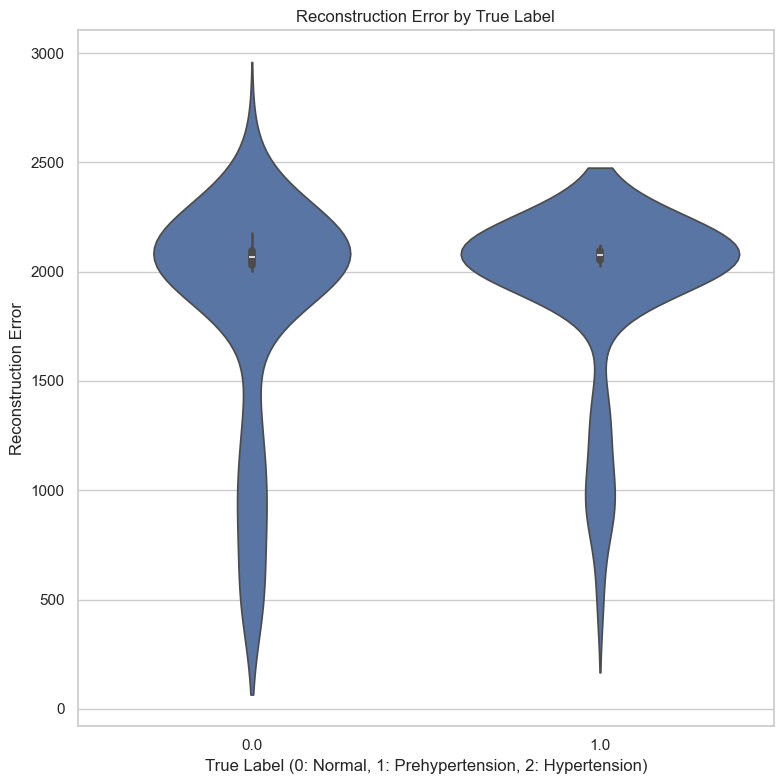

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

# 스타일 설정
sns.set(style="whitegrid")

# 바이올린 플롯 그리기
plt.figure(figsize=(8, 8))
sns.violinplot(data=anomaly_df, x="True_Label", y="Reconstruction_Error", inner="box")

# 필요 시 임계선 추가
# plt.axhline(y=th, color='red', linestyle='--', label=f'Threshold = {th:.2f}')

# 라벨 및 타이틀 설정
plt.title("Reconstruction Error by True Label")
plt.xlabel("True Label (0: Normal, 1: Prehypertension, 2: Hypertension)")
plt.ylabel("Reconstruction Error")

# 필요 시 로그 스케일
# plt.yscale("log")

plt.tight_layout()
plt.show()




In [109]:
threshold = 2122.2729

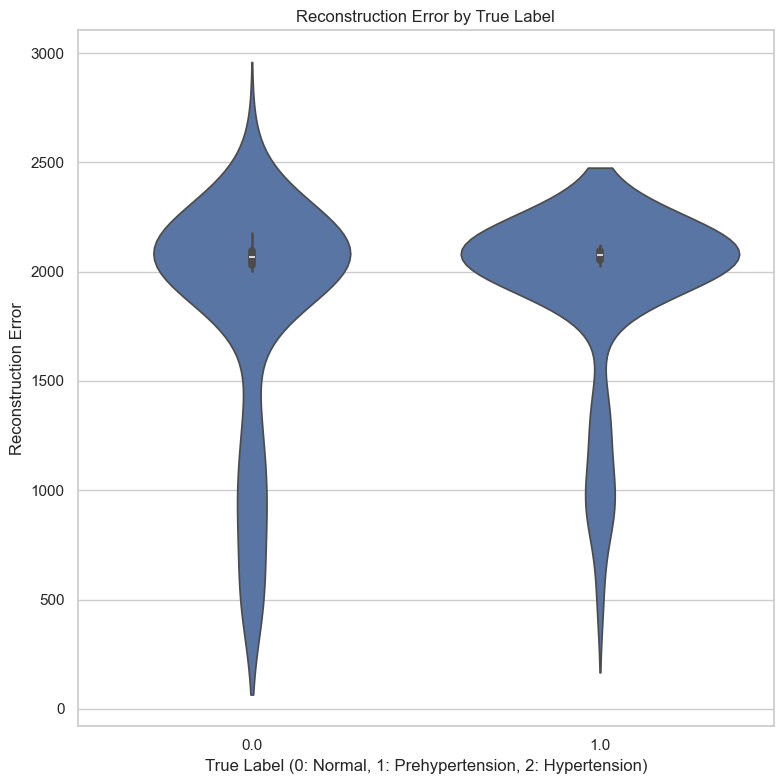

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

# 스타일 설정
sns.set(style="whitegrid")

# 바이올린 플롯 그리기
plt.figure(figsize=(8, 8))
sns.violinplot(data=anomaly_df, x="True_Label", y="Reconstruction_Error", inner="box")

# 필요 시 임계선 추가
# plt.axhline(y=th, color='red', linestyle='--', label=f'Threshold = {th:.2f}')

# 라벨 및 타이틀 설정
plt.title("Reconstruction Error by True Label")
plt.xlabel("True Label (0: Normal, 1: Prehypertension, 2: Hypertension)")
plt.ylabel("Reconstruction Error")

# 필요 시 로그 스케일
# plt.yscale("log")

plt.tight_layout()
plt.show()


이상 탐지 성공 (TP): 57건
이상 탐지 실패 (FN): 1건
정상 탐지 성공 (TN): 10건
정상 탐지 실패 (FP): 55건

📊 Precision: 0.5089
📊 Recall:    0.9828
📊 F1-score:  0.6706
📈 AUC:       0.4584


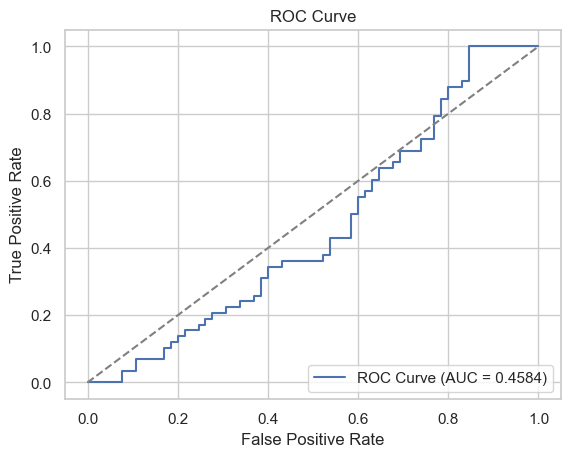

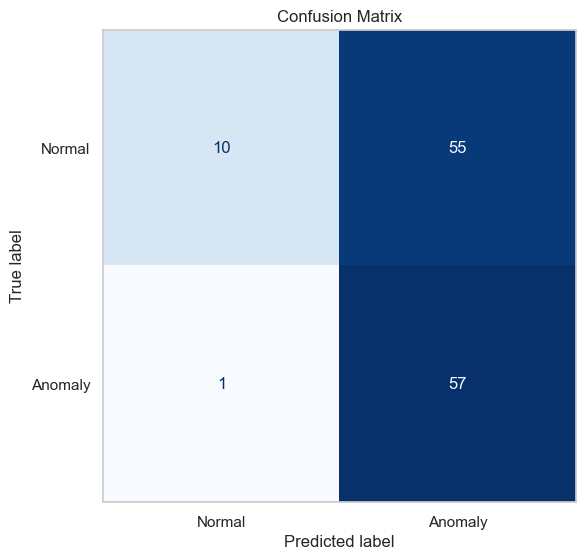

In [111]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
import matplotlib.pyplot as plt

# 이상 탐지 성공 (True Positive): Reconstruction_Error < threshold & Label in [1.0, 2.0]
cond_anomaly_detected = (anomaly_df['Reconstruction_Error'] < threshold) & (anomaly_df['True_Label'].isin([1.0, 2.0]))
anomaly_detected_count = cond_anomaly_detected.sum()

# 이상 탐지 실패 (False Negative): Reconstruction_Error >= threshold & Label in [1.0, 2.0]
cond_anomaly_missed = (anomaly_df['Reconstruction_Error'] >= threshold) & (anomaly_df['True_Label'].isin([1.0, 2.0]))
anomaly_missed_count = cond_anomaly_missed.sum()

# 정상 탐지 성공 (True Negative): Reconstruction_Error >= threshold & Label == 0.0
cond_normal_detected = (anomaly_df['Reconstruction_Error'] >= threshold) & (anomaly_df['True_Label'] == 0.0)
normal_detected_count = cond_normal_detected.sum()

# 정상 탐지 실패 (False Positive): Reconstruction_Error < threshold & Label == 0.0
cond_normal_missed = (anomaly_df['Reconstruction_Error'] < threshold) & (anomaly_df['True_Label'] == 0.0)
normal_missed_count = cond_normal_missed.sum()

# 출력
print(f"이상 탐지 성공 (TP): {anomaly_detected_count}건")
print(f"이상 탐지 실패 (FN): {anomaly_missed_count}건")
print(f"정상 탐지 성공 (TN): {normal_detected_count}건")
print(f"정상 탐지 실패 (FP): {normal_missed_count}건")


# 이진 분류를 위한 예측 라벨 생성 (이상: 1, 정상: 0)
# Reconstruction_Error가 threshold보다 작으면 이상으로 예측 (이상은 재구성 오류가 낮다 가정)
pred_labels = (anomaly_df['Reconstruction_Error'] < threshold).astype(int)
true_labels = anomaly_df['True_Label'].apply(lambda x: 1 if x in [1.0, 2.0] else 0)

# 정밀도, 재현율, F1 점수
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, -anomaly_df['Reconstruction_Error'])  # 낮을수록 이상으로 간주

print(f"\n📊 Precision: {precision:.4f}")
print(f"📊 Recall:    {recall:.4f}")
print(f"📊 F1-score:  {f1:.4f}")
print(f"📈 AUC:       {roc_auc:.4f}")


# ROC Curve 시각화
fpr, tpr, thresholds = roc_curve(true_labels, -anomaly_df['Reconstruction_Error'])  # 이상일수록 값 작음
roc_auc_val = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_val:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix 계산
cm = confusion_matrix(true_labels, pred_labels)

# 시각화 객체 생성 및 출력
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)  # colorbar 생략 가능

# 제목 및 그리드 설정
ax.set_title("Confusion Matrix")
ax.grid(False)

plt.tight_layout()
plt.show()
